In [37]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import time
from datetime import datetime

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    mean_absolute_percentage_error
)

# Models
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor,
    ExtraTreesRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import shap
# # SHAP
# try:
#     import shap
# except:
#     !pip install shap
#     import shap

import joblib

# Set seed
np.random.seed(42)

# Plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("All libraries imported successfully")

All libraries imported successfully


# Load Data set

In [38]:
# Load data
df = pd.read_csv('./data/global_sports_footwear_sales_2018_2026.csv')

print(f"Data shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Data shape: (30000, 18)

Columns: ['order_id', 'order_date', 'brand', 'model_name', 'category', 'gender', 'size', 'color', 'base_price_usd', 'discount_percent', 'final_price_usd', 'units_sold', 'revenue_usd', 'payment_method', 'sales_channel', 'country', 'customer_income_level', 'customer_rating']

First few rows:


,order_id,order_date,brand,model_name,category,gender,size,color,base_price_usd,discount_percent,final_price_usd,units_sold,revenue_usd,payment_method,sales_channel,country,customer_income_level,customer_rating
0,ORD100000,2021-01-30,ASICS,Model-370,Running,Unisex,8,Black,162,15,137.70,1,137.7,Card,Retail Store,Germany,Low,4.6
1,ORD100001,2026-10-05,Reebok,Model-314,Lifestyle,Men,8,Grey,80,5,76.00,3,228.0,Card,Online,USA,Low,3.9
2,ORD100002,2023-11-12,ASICS,Model-763,Lifestyle,Men,8,Black,176,15,149.60,4,598.4,Cash,Retail Store,India,Medium,3.0
3,ORD100003,2026-08-29,Reebok,Model-905,Basketball,Women,7,White,61,15,51.85,2,103.7,Card,Retail Store,India,High,3.4
4,ORD100004,2019-11-09,Nike,Model-413,Training,Men,11,Black,80,0,80.00,4,320.0,Cash,Online,USA,Medium,3.0


In [39]:
# Check data info
print("Data Info:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

print("\nTarget variable statistics:")
df['final_price_usd'].describe()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id               30000 non-null  object 
 1   order_date             30000 non-null  object 
 2   brand                  30000 non-null  object 
 3   model_name             30000 non-null  object 
 4   category               30000 non-null  object 
 5   gender                 30000 non-null  object 
 6   size                   30000 non-null  int64  
 7   color                  30000 non-null  object 
 8   base_price_usd         30000 non-null  int64  
 9   discount_percent       30000 non-null  int64  
 10  final_price_usd        30000 non-null  float64
 11  units_sold             30000 non-null  int64  
 12  revenue_usd            30000 non-null  float64
 13  payment_method         30000 non-null  object 
 14  sales_channel          30000 non-null  obje

count    30000.000000
mean       121.029035
std         42.511586
min         42.000000
25%         85.000000
50%        119.200000
75%        153.600000
max        219.000000
Name: final_price_usd, dtype: float64

In [11]:
df.describe()

,size,base_price_usd,discount_percent,final_price_usd,units_sold,revenue_usd,customer_rating
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,8.500867,139.634633,13.332167,121.029035,2.500200,302.714948,4.001543
std,1.710896,46.062549,9.864198,42.511586,1.121149,179.149272,0.577546
min,6.000000,60.000000,0.000000,42.000000,1.000000,42.000000,3.000000
25%,7.000000,100.000000,5.000000,85.000000,1.000000,156.750000,3.500000
50%,9.000000,140.000000,10.000000,119.200000,3.000000,268.200000,4.000000
75%,10.000000,180.000000,20.000000,153.600000,4.000000,414.000000,4.500000
max,11.000000,219.000000,30.000000,219.000000,4.000000,876.000000,5.000000


# Data proprocessing

In [123]:
# Make a copy
data = df.copy()

# # Remove rows with missing target
# if data['final_price_usd'].isnull().sum() > 0:
#     print(f"Removing {data['final_price_usd'].isnull().sum()} rows with missing target")
#     data = data[~data['final_price_usd'].isnull()]

# Separate target and features
y = data['revenue_usd']

# Remove features that contain target information
leaked_features = [
    'final_price_usd',  # Target itself
    'revenue_usd',      # This is final_price * units_sold - LEAKAGE!
    'order_id',         # Non-informative
    'discount_percent'
]

# Only keep legitimate features
X = data.drop(columns=leaked_features)

# Extract date features
if 'order_date' in X.columns:
    print("\nExtracting date features...")
    X['order_date'] = pd.to_datetime(X['order_date'])
    X['order_year'] = X['order_date'].dt.year
    X['order_month'] = X['order_date'].dt.month
    X['order_day'] = X['order_date'].dt.day
    X['order_dayofweek'] = X['order_date'].dt.dayofweek
    X['order_quarter'] = X['order_date'].dt.quarter
    X = X.drop(columns=['order_date'])

# Identify column types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = X[col].fillna('missing')
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"  Encoded '{col}': {len(le.classes_)} categories")

# Fill missing numerical values
for col in numerical_cols:
    if X[col].isnull().sum() > 0:
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        print(f"  Filled '{col}' with median: {median_val}")

print(f"\n✓ Preprocessing complete")
print(f"  Final shape: {X.shape}")
print(f"  No missing values: {X.isnull().sum().sum() == 0}")


Extracting date features...

Categorical columns (9): ['brand', 'model_name', 'category', 'gender', 'color', 'payment_method', 'sales_channel', 'country', 'customer_income_level']
Numerical columns (9): ['size', 'base_price_usd', 'units_sold', 'customer_rating', 'order_year', 'order_month', 'order_day', 'order_dayofweek', 'order_quarter']
  Encoded 'brand': 6 categories
  Encoded 'model_name': 899 categories
  Encoded 'category': 5 categories
  Encoded 'gender': 3 categories
  Encoded 'color': 5 categories
  Encoded 'payment_method': 4 categories
  Encoded 'sales_channel': 2 categories
  Encoded 'country': 6 categories
  Encoded 'customer_income_level': 3 categories

✓ Preprocessing complete
  Final shape: (30000, 18)
  No missing values: True


# Explore Data

In [124]:
# print unique value for each columns

for col in df.columns:
    print(f"{col}: \n{df[col].unique()}\n")


order_id: 
['ORD100000' 'ORD100001' 'ORD100002' ... 'ORD129997' 'ORD129998'
 'ORD129999']

order_date: 
['2021-01-30' '2026-10-05' '2023-11-12' ... '2022-09-29' '2026-03-04'
 '2020-01-06']

brand: 
['ASICS' 'Reebok' 'Nike' 'New Balance' 'Adidas' 'Puma']

model_name: 
['Model-370' 'Model-314' 'Model-763' 'Model-905' 'Model-413' 'Model-158'
 'Model-786' 'Model-604' 'Model-266' 'Model-876' 'Model-554' 'Model-661'
 'Model-871' 'Model-261' 'Model-351' 'Model-316' 'Model-912' 'Model-747'
 'Model-388' 'Model-300' 'Model-904' 'Model-712' 'Model-866' 'Model-991'
 'Model-195' 'Model-270' 'Model-185' 'Model-745' 'Model-430' 'Model-732'
 'Model-510' 'Model-212' 'Model-906' 'Model-180' 'Model-954' 'Model-229'
 'Model-346' 'Model-393' 'Model-223' 'Model-863' 'Model-246' 'Model-739'
 'Model-572' 'Model-996' 'Model-108' 'Model-251' 'Model-724' 'Model-211'
 'Model-995' 'Model-780' 'Model-915' 'Model-121' 'Model-875' 'Model-383'
 'Model-646' 'Model-472' 'Model-401' 'Model-260' 'Model-665' 'Model-953'
 '

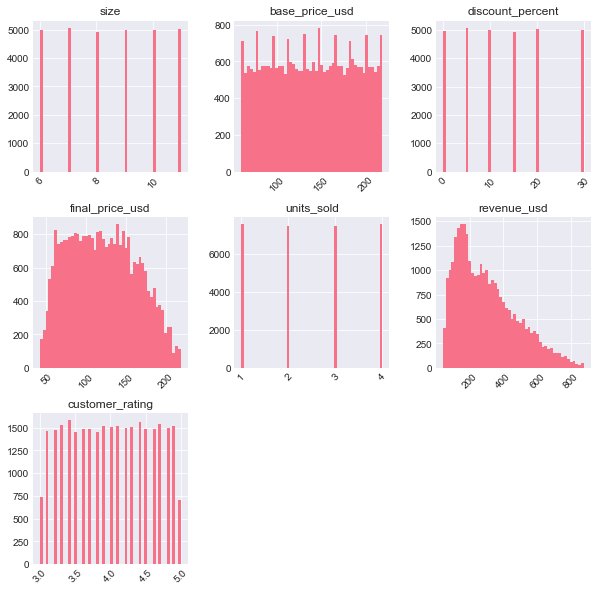

In [125]:
df.hist(figsize=(10,10), xrot=45,bins=50)
plt.show()

In [126]:
# extracting the numerical columns

num_df = df.select_dtypes(include = ['int64', 'float64'])

# extracting categorical columns

cat_df = df.select_dtypes(include = ['object'])

for col in cat_df.columns:
    print(f"{col}: \n{cat_df[col].unique()}\n")

order_id: 
['ORD100000' 'ORD100001' 'ORD100002' ... 'ORD129997' 'ORD129998'
 'ORD129999']

order_date: 
['2021-01-30' '2026-10-05' '2023-11-12' ... '2022-09-29' '2026-03-04'
 '2020-01-06']

brand: 
['ASICS' 'Reebok' 'Nike' 'New Balance' 'Adidas' 'Puma']

model_name: 
['Model-370' 'Model-314' 'Model-763' 'Model-905' 'Model-413' 'Model-158'
 'Model-786' 'Model-604' 'Model-266' 'Model-876' 'Model-554' 'Model-661'
 'Model-871' 'Model-261' 'Model-351' 'Model-316' 'Model-912' 'Model-747'
 'Model-388' 'Model-300' 'Model-904' 'Model-712' 'Model-866' 'Model-991'
 'Model-195' 'Model-270' 'Model-185' 'Model-745' 'Model-430' 'Model-732'
 'Model-510' 'Model-212' 'Model-906' 'Model-180' 'Model-954' 'Model-229'
 'Model-346' 'Model-393' 'Model-223' 'Model-863' 'Model-246' 'Model-739'
 'Model-572' 'Model-996' 'Model-108' 'Model-251' 'Model-724' 'Model-211'
 'Model-995' 'Model-780' 'Model-915' 'Model-121' 'Model-875' 'Model-383'
 'Model-646' 'Model-472' 'Model-401' 'Model-260' 'Model-665' 'Model-953'
 '

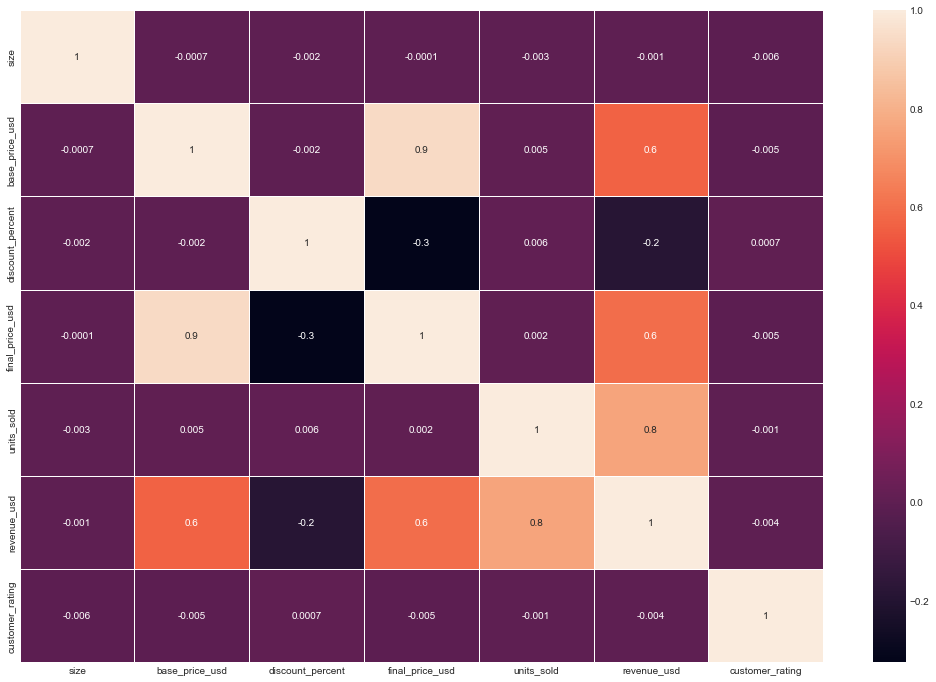

In [127]:
# Heatmap correlation plot for all variables

plt.figure(figsize = (18, 12))

corr = num_df.corr()
sns.heatmap(data = corr,  annot = True, fmt = '.1g', linewidth = 1)
plt.show()

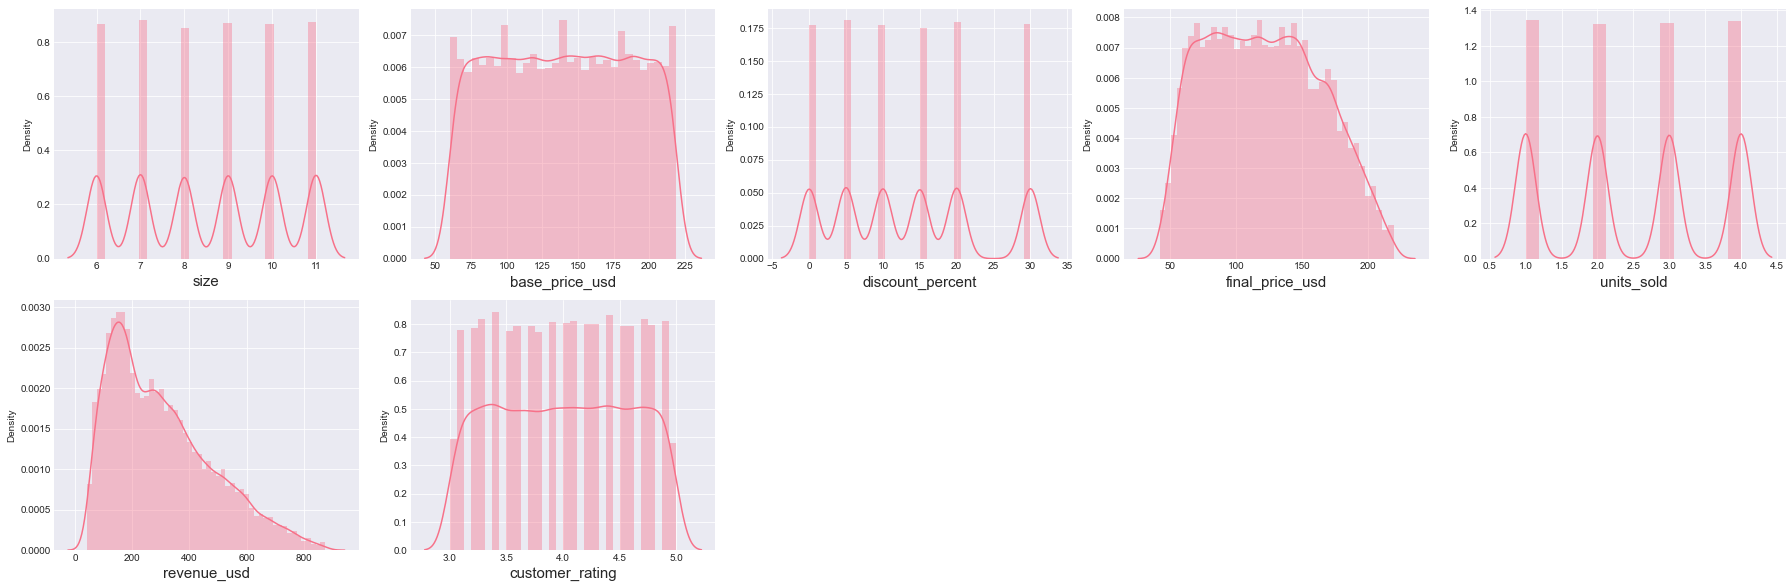

In [128]:
# Histogram of Continuous variable
plt.figure(figsize = (25, 20))
plotnumber = 1

for col in num_df.columns:
    if plotnumber <= 24:
        ax = plt.subplot(5, 5, plotnumber)
        sns.distplot(num_df[col])
        plt.xlabel(col, fontsize = 15)
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

## 3. Train-Test Split

In [129]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

Train set: 24000 samples
Test set: 6000 samples
Features: 18


# Model Training

In [130]:
# Define regressors
regressors = [
    ['Ridge', Ridge(random_state=42)],
    ['Lasso', Lasso(random_state=42, max_iter=5000)],
    ['ElasticNet', ElasticNet(random_state=42, max_iter=5000)],
    #['DecisionTree', DecisionTreeRegressor(random_state=42)],
    #['RandomForest', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)],
    ['GradientBoosting', GradientBoostingRegressor(random_state=42)],
    #['ExtraTrees', ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)],
    ['XGBoost', XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)],
    ['LightGBM', LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)],
    ['CatBoost', CatBoostRegressor(random_state=42, verbose=0)],
    #['KNN', KNeighborsRegressor(n_neighbors=5)]
]

model_results = []
trained_models = {}

print("Training models...\n")

for name, model in regressors:
    print(f"Training {name}...", end=' ')
    start_time = time.time()
    
    try:
        # Train
        model.fit(X_train, y_train)
        runtime = time.time() - start_time
        
        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Store
        model_results.append({
            "model_name": name,
            "model": model,
            "runtime": runtime,
            "y_train": y_train,
            "y_test": y_test,
            "y_train_pred": y_train_pred,
            "y_test_pred": y_test_pred
        })
        
        trained_models[name] = model
        print(f"✓ ({runtime:.2f}s)")
        
    except Exception as e:
        print(f"✗ Failed: {e}")

print(f"\n✓ Successfully trained {len(trained_models)} models")

Training models...

Training Ridge... ✓ (0.01s)
Training Lasso... ✓ (0.01s)
Training ElasticNet... ✓ (0.49s)
Training GradientBoosting... ✓ (3.19s)
Training XGBoost... ✓ (0.21s)
Training LightGBM... ✓ (0.21s)
Training CatBoost... ✓ (4.78s)

✓ Successfully trained 7 models


# Model Evaluation

In [131]:
rows = []

for res in model_results:
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(res['y_train'], res['y_train_pred']))
    test_rmse = np.sqrt(mean_squared_error(res['y_test'], res['y_test_pred']))
    
    train_mae = mean_absolute_error(res['y_train'], res['y_train_pred'])
    test_mae = mean_absolute_error(res['y_test'], res['y_test_pred'])
    
    train_r2 = r2_score(res['y_train'], res['y_train_pred'])
    test_r2 = r2_score(res['y_test'], res['y_test_pred'])
    
    try:
        train_mape = mean_absolute_percentage_error(res['y_train'], res['y_train_pred']) * 100
        test_mape = mean_absolute_percentage_error(res['y_test'], res['y_test_pred']) * 100
    except:
        train_mape = np.nan
        test_mape = np.nan
    
    diff_r2 = train_r2 - test_r2
    is_overfitting = diff_r2 > 0.15
    
    rows.append({
        "model_name": res["model_name"],
        "runtime": round(res["runtime"], 3),
        "train_rmse": round(train_rmse, 4),
        "test_rmse": round(test_rmse, 4),
        "train_mae": round(train_mae, 4),
        "test_mae": round(test_mae, 4),
        "train_r2": round(train_r2, 4),
        "test_r2": round(test_r2, 4),
        "train_mape": round(train_mape, 4),
        "test_mape": round(test_mape, 4),
        "r2_diff": round(diff_r2, 4),
        "is_overfitting": is_overfitting
    })

results_df = pd.DataFrame(rows)

# Mark best model
best_idx = results_df["test_r2"].idxmax()
results_df["is_best_model"] = False
results_df.loc[best_idx, "is_best_model"] = True

print("Model Comparison Results:")
print("="*120)
display(results_df.style.highlight_max(subset=['test_r2'], color='lightgreen')
                         .highlight_min(subset=['test_rmse', 'test_mae'], color='lightgreen'))

best_model_name = results_df.loc[best_idx, "model_name"]
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test R²: {results_df.loc[best_idx, 'test_r2']:.4f}")
print(f"   Test RMSE: {results_df.loc[best_idx, 'test_rmse']:.4f}")
print(f"   Test MAE: {results_df.loc[best_idx, 'test_mae']:.4f}")

Model Comparison Results:


,model_name,runtime,train_rmse,test_rmse,train_mae,test_mae,train_r2,test_r2,train_mape,test_mape,r2_diff,is_overfitting,is_best_model
0,Ridge,0.011000,59.634600,59.609900,47.296900,47.031300,0.889100,0.889700,23.646000,24.277800,-0.000600,False,False
1,Lasso,0.014000,59.652100,59.596100,47.256100,46.955900,0.889000,0.889800,23.515300,24.120000,-0.000800,False,False
2,ElasticNet,0.491000,71.220600,70.774400,52.502400,51.670800,0.841800,0.844500,22.301000,22.128000,-0.002700,False,False
3,GradientBoosting,3.194000,39.668300,39.015400,29.006500,28.441900,0.950900,0.952800,9.931900,9.887300,-0.001800,False,True
4,XGBoost,0.214000,28.535400,41.175600,21.267000,29.887400,0.974600,0.947400,7.787100,10.522800,0.027200,False,False
5,LightGBM,0.211000,36.276000,39.302900,27.047600,28.533100,0.959000,0.952100,9.490500,9.885700,0.006900,False,False
6,CatBoost,4.785000,32.958000,39.550800,24.574400,28.857400,0.966100,0.951400,8.705900,10.109700,0.014700,False,False



🏆 BEST MODEL: GradientBoosting
   Test R²: 0.9528
   Test RMSE: 39.0154
   Test MAE: 28.4419


# Hyperparameter Tuning

In [132]:
# Parameter grids
param_grids = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]},
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 70]
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [4, 6, 8]
    }
}

param_grid = param_grids.get(best_model_name, {})

if param_grid:
    print(f"Tuning {best_model_name}...")
    print(f"Parameter grid: {param_grid}")
    
    grid = GridSearchCV(
        estimator=trained_models[best_model_name],
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    best_model_tuned = grid.best_estimator_
    y_test_pred_tuned = best_model_tuned.predict(X_test)
    
    print(f"\nBest parameters: {grid.best_params_}")
    print(f"Best CV R² score: {grid.best_score_:.4f}")
    print(f"\nTest set performance:")
    print(f"  R²: {r2_score(y_test, y_test_pred_tuned):.4f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_tuned)):.4f}")
    print(f"  MAE: {mean_absolute_error(y_test, y_test_pred_tuned):.4f}")
    
else:
    print(f"No parameter grid for {best_model_name}")
    best_model_tuned = trained_models[best_model_name]
    y_test_pred_tuned = best_model_tuned.predict(X_test)

Tuning GradientBoosting...
Parameter grid: {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best CV R² score: 0.9491

Test set performance:
  R²: 0.9528
  RMSE: 39.0154
  MAE: 28.4419


# SHAP Feature Importance Analysis

In [136]:
# Sample data for SHAP
sample_size_train = min(1000, len(X_train))
sample_size_test = min(500, len(X_test))

sample_indices_train = np.random.choice(len(X_train), sample_size_train, replace=False)
sample_indices_test = np.random.choice(len(X_test), sample_size_test, replace=False)

X_train_sample = X_train.iloc[sample_indices_train]
X_test_sample = X_test.iloc[sample_indices_test]

print(f"Creating SHAP explainer for {best_model_name}...")

try:
    if best_model_name in ['RandomForest', 'GradientBoosting', 'ExtraTrees', 
                            'XGBoost', 'LightGBM', 'CatBoost', 'DecisionTree']:
        explainer = shap.TreeExplainer(best_model_tuned)
        shap_values = explainer.shap_values(X_test_sample)
    else:
        explainer = shap.Explainer(best_model_tuned.predict, X_train_sample)
        shap_values_obj = explainer(X_test_sample)
        shap_values = shap_values_obj.values
    
    print("✓ SHAP values calculated")
    
    # Feature importance
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': mean_abs_shap
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    display(feature_importance.head(20))
    
except Exception as e:
    print(f"SHAP error: {e}")
    shap_values = None

Creating SHAP explainer for GradientBoosting...
✓ SHAP values calculated

Top 20 Most Important Features:


,feature,importance
7,units_sold,119.774298
6,base_price_usd,92.419020
1,model_name,0.399410
5,color,0.371724
10,country,0.330418
12,customer_rating,0.219071
15,order_day,0.197145
13,order_year,0.187600
14,order_month,0.169412
16,order_dayofweek,0.158403


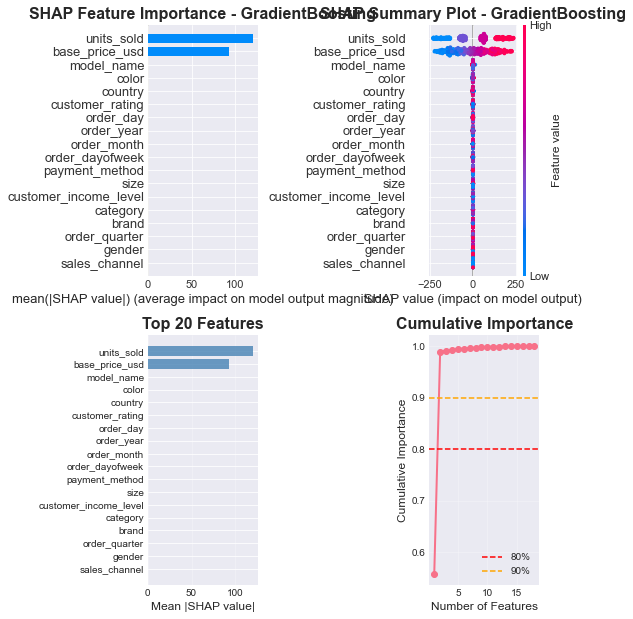

In [137]:
# SHAP Visualizations
if shap_values is not None:
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Summary plot (bar)
    plt.sca(axes[0, 0])
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", 
                      max_display=20, show=False)
    axes[0, 0].set_title(f'SHAP Feature Importance - {best_model_name}', 
                         fontsize=16, fontweight='bold')
    
    # Summary plot (beeswarm)
    plt.sca(axes[0, 1])
    shap.summary_plot(shap_values, X_test_sample, max_display=20, show=False)
    axes[0, 1].set_title(f'SHAP Summary Plot - {best_model_name}', 
                         fontsize=16, fontweight='bold')
    
    # Bar chart
    top_features = feature_importance.head(20)
    axes[1, 0].barh(range(len(top_features)), top_features['importance'], 
                    color='steelblue', alpha=0.8)
    axes[1, 0].set_yticks(range(len(top_features)))
    axes[1, 0].set_yticklabels(top_features['feature'])
    axes[1, 0].invert_yaxis()
    axes[1, 0].set_xlabel('Mean |SHAP value|', fontsize=12)
    axes[1, 0].set_title('Top 20 Features', fontsize=16, fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # Cumulative
    feature_importance['cumulative'] = (
        feature_importance['importance'].cumsum() / 
        feature_importance['importance'].sum()
    )
    axes[1, 1].plot(range(1, len(feature_importance) + 1), 
                    feature_importance['cumulative'].values, 
                    marker='o', linewidth=2)
    axes[1, 1].axhline(y=0.8, color='r', linestyle='--', label='80%')
    axes[1, 1].axhline(y=0.9, color='orange', linestyle='--', label='90%')
    axes[1, 1].set_xlabel('Number of Features', fontsize=12)
    axes[1, 1].set_ylabel('Cumulative Importance', fontsize=12)
    axes[1, 1].set_title('Cumulative Importance', fontsize=16, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Model Comparison Visualizations

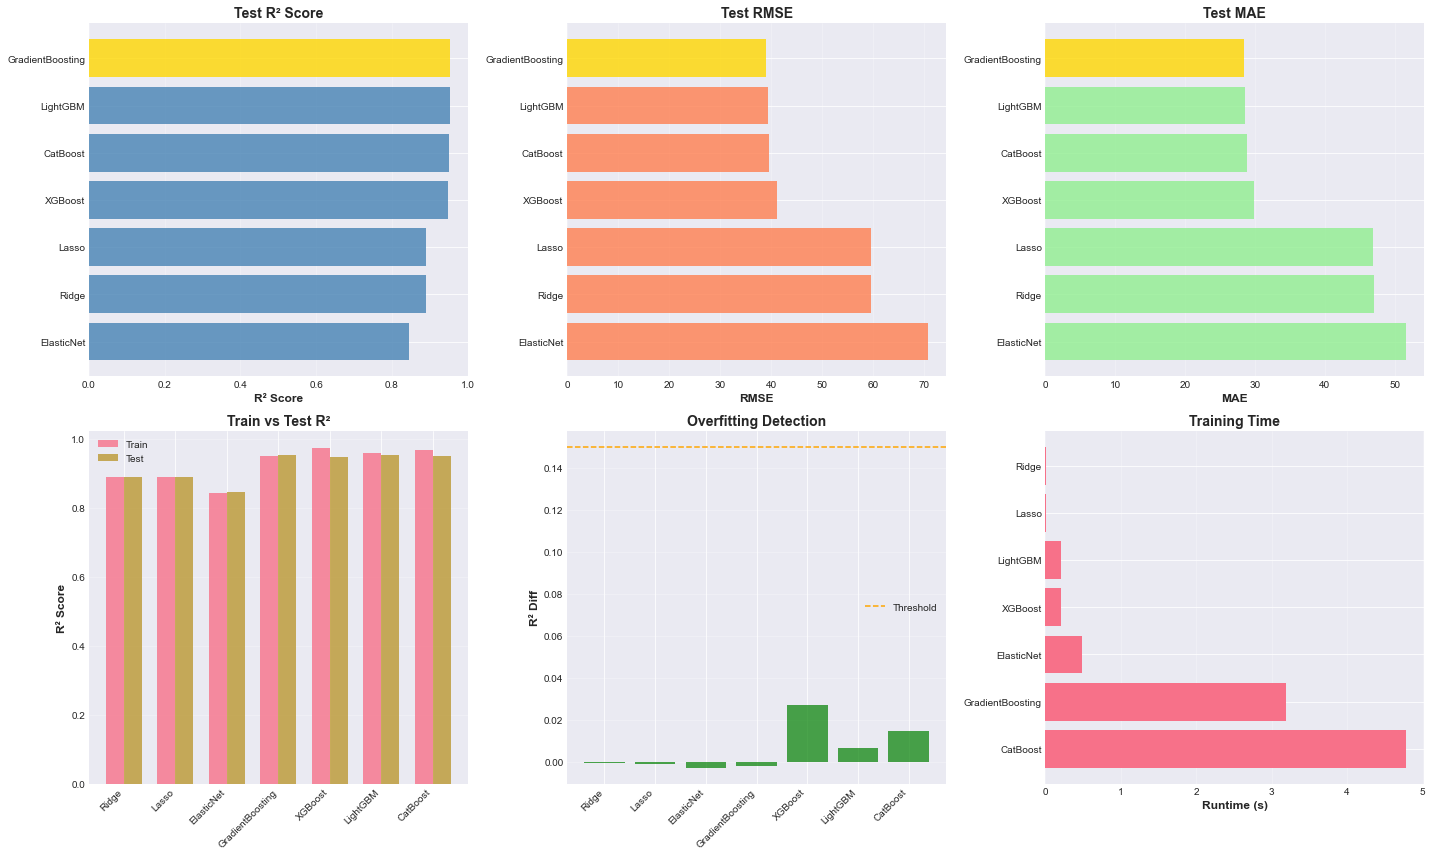

In [138]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Test R2
results_sorted = results_df.sort_values('test_r2', ascending=True)
colors = ['gold' if row['is_best_model'] else 'steelblue' 
          for _, row in results_sorted.iterrows()]
axes[0, 0].barh(results_sorted['model_name'], results_sorted['test_r2'], 
                color=colors, alpha=0.8)
axes[0, 0].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Test R² Score', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Test RMSE
results_rmse = results_df.sort_values('test_rmse', ascending=False)
colors_rmse = ['gold' if row['is_best_model'] else 'coral' 
               for _, row in results_rmse.iterrows()]
axes[0, 1].barh(results_rmse['model_name'], results_rmse['test_rmse'], 
                color=colors_rmse, alpha=0.8)
axes[0, 1].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Test RMSE', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Test MAE
results_mae = results_df.sort_values('test_mae', ascending=False)
colors_mae = ['gold' if row['is_best_model'] else 'lightgreen' 
              for _, row in results_mae.iterrows()]
axes[0, 2].barh(results_mae['model_name'], results_mae['test_mae'], 
                color=colors_mae, alpha=0.8)
axes[0, 2].set_xlabel('MAE', fontsize=12, fontweight='bold')
axes[0, 2].set_title('Test MAE', fontsize=14, fontweight='bold')
axes[0, 2].grid(axis='x', alpha=0.3)

# 4. Train vs Test R2
x = np.arange(len(results_df))
width = 0.35
axes[1, 0].bar(x - width/2, results_df['train_r2'], width, 
               label='Train', alpha=0.8)
axes[1, 0].bar(x + width/2, results_df['test_r2'], width, 
               label='Test', alpha=0.8)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(results_df['model_name'], rotation=45, ha='right')
axes[1, 0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Train vs Test R²', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Overfitting
colors_overfit = ['red' if x else 'green' for x in results_df['is_overfitting']]
axes[1, 1].bar(results_df['model_name'], results_df['r2_diff'], 
               color=colors_overfit, alpha=0.7)
axes[1, 1].axhline(y=0.15, color='orange', linestyle='--', label='Threshold')
axes[1, 1].set_ylabel('R² Diff', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Overfitting Detection', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 6. Runtime
results_runtime = results_df.sort_values('runtime', ascending=False)
axes[1, 2].barh(results_runtime['model_name'], results_runtime['runtime'])
axes[1, 2].set_xlabel('Runtime (s)', fontsize=12, fontweight='bold')
axes[1, 2].set_title('Training Time', fontsize=14, fontweight='bold')
axes[1, 2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Prediction Analysis

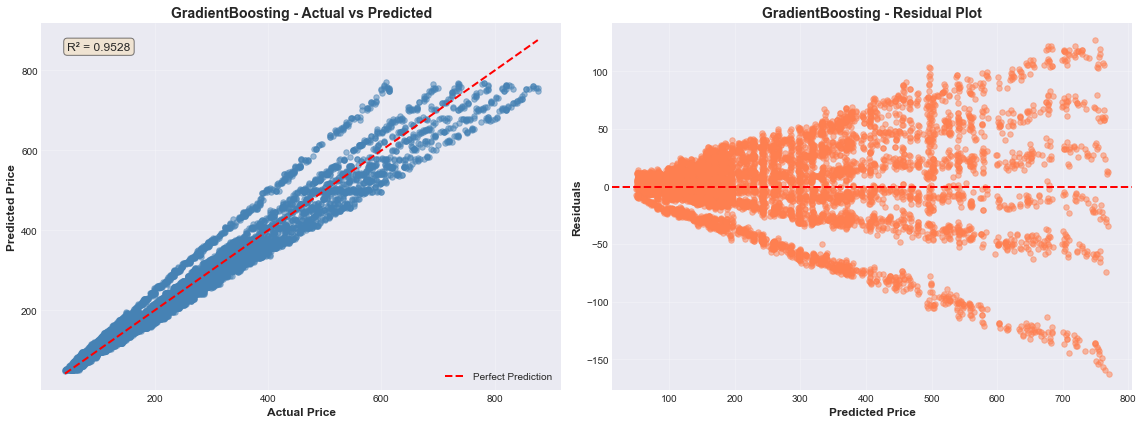

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred_tuned, alpha=0.5, s=30, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Price', fontsize=12, fontweight='bold')
axes[0].set_title(f'{best_model_name} - Actual vs Predicted', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

test_r2 = r2_score(y_test, y_test_pred_tuned)
axes[0].text(0.05, 0.95, f'R² = {test_r2:.4f}', 
             transform=axes[0].transAxes, fontsize=12,
             verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Residual plot
residuals = y_test - y_test_pred_tuned
axes[1].scatter(y_test_pred_tuned, residuals, alpha=0.5, s=30, color='coral')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[1].set_title(f'{best_model_name} - Residual Plot', 
                  fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary

In [140]:
print("="*80)
print("ANALYSIS SUMMARY")
print("="*80)
print(f"\nDataset: {len(df)} samples, {X_train.shape[1]} features")
print(f"Train/Test: {len(X_train)}/{len(X_test)}")
print(f"\nTarget (final_price_usd):")
print(f"  Mean: ${y.mean():.2f}")
print(f"  Std: ${y.std():.2f}")
print(f"  Range: ${y.min():.2f} - ${y.max():.2f}")
print(f"\nModels trained: {len(trained_models)}")
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"  Test R²: {results_df.loc[best_idx, 'test_r2']:.4f}")
print(f"  Test RMSE: ${results_df.loc[best_idx, 'test_rmse']:.2f}")
print(f"  Test MAE: ${results_df.loc[best_idx, 'test_mae']:.2f}")
print(f"  Test MAPE: {results_df.loc[best_idx, 'test_mape']:.2f}%")

if shap_values is not None:
    print(f"\nTop 5 Important Features:")
    for i, row in feature_importance.head(5).iterrows():
        print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

ANALYSIS SUMMARY

Dataset: 30000 samples, 18 features
Train/Test: 24000/6000

Target (final_price_usd):
  Mean: $302.71
  Std: $179.15
  Range: $42.00 - $876.00

Models trained: 7

🏆 BEST MODEL: GradientBoosting
  Test R²: 0.9528
  Test RMSE: $39.02
  Test MAE: $28.44
  Test MAPE: 9.89%

Top 5 Important Features:
  8. units_sold: 119.7743
  7. base_price_usd: 92.4190
  2. model_name: 0.3994
  6. color: 0.3717
  11. country: 0.3304


In [23]:
# separating the feature and target columns

# outcome
y = num_df['final_price_usd']

# features
num_df.drop('final_price_usd', inplace = True ,axis = 1)

In [24]:
# categorical variable to dummies

cat_df = pd.get_dummies(cat_df, drop_first = True)

In [25]:
# combining the Numerical and Categorical dataframes to get the final dataset

X = pd.concat([num_df, cat_df], axis = 1)

# Modeling

In [26]:
# splitting data into training set and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import shap


In [29]:
regressors = [
    ['RandomForest', RandomForestRegressor(random_state=42)],
    ['GradientBoosting', GradientBoostingRegressor(random_state=42)],
    ['XGBoost', XGBRegressor(random_state=42, verbosity=0)],
    ['LightGBM', LGBMRegressor(random_state=42)]
]

# Modelling Function

In [30]:
def modelling_regression(regressors, X_train, y_train, X_test, y_test):
    
    model_results = []

    for name, model in regressors:
        start_time = time.time()

        model.fit(X_train, y_train)

        runtime = time.time() - start_time

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        model_results.append({
            "model_name": name,
            "runtime": runtime,
            "y_train": y_train,
            "y_test": y_test,
            "y_train_pred": y_train_pred,
            "y_test_pred": y_test_pred
        })

    return model_results


# Evaluation Function (Regression Metrics + Overfitting Check)

In [31]:
def process_eval_regression(model_results, overfit_threshold=20):
    
    rows = []

    for res in model_results:
        y_train = res["y_train"]
        y_test = res["y_test"]
        y_train_pred = res["y_train_pred"]
        y_test_pred = res["y_test_pred"]

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        diff = train_rmse - test_rmse
        diff_percentage = (diff / train_rmse) * 100
        is_overfitting = diff_percentage > overfit_threshold

        rows.append({
            "model_name": res["model_name"],
            "runtime": round(res["runtime"], 3),
            "train_rmse": round(train_rmse, 3),
            "test_rmse": round(test_rmse, 3),
            "train_mae": round(train_mae, 3),
            "test_mae": round(test_mae, 3),
            "train_r2": round(train_r2, 4),
            "test_r2": round(test_r2, 4),
            "diff_percentage": round(diff_percentage, 2),
            "is_overfitting": is_overfitting
        })

    df = pd.DataFrame(rows)

    # Best model = lowest test RMSE
    best_idx = df["test_rmse"].idxmin()
    df["is_best_model"] = False
    df.loc[best_idx, "is_best_model"] = True

    return df


# Run all Models

In [32]:
model_result = modelling_regression(regressors, X_train, y_train, X_test, y_test)
result = process_eval_regression(model_result)

result


MemoryError: Unable to allocate 3.06 GiB for an array with shape (34215, 24000) and data type float32

# Parameter Grid for Tuning

In [33]:
def get_param_grid(model_name):
    
    if model_name == "RandomForest":
        return {
            "model__n_estimators": [200, 400],
            "model__max_depth": [10, 20, None],
            "model__min_samples_split": [2, 5]
        }

    if model_name == "XGBoost":
        return {
            "model__n_estimators": [300, 500],
            "model__max_depth": [4, 8],
            "model__learning_rate": [0.01, 0.1]
        }

    if model_name == "LightGBM":
        return {
            "model__n_estimators": [300, 500],
            "model__num_leaves": [31, 64],
            "model__learning_rate": [0.01, 0.1]
        }

    if model_name == "CatBoost":
        return {
            "model__iterations": [300, 500],
            "model__depth": [6, 8],
            "model__learning_rate": [0.01, 0.1]
        }

    if model_name == "GradientBoosting":
        return {
            "model__n_estimators": [200, 400],
            "model__learning_rate": [0.01, 0.1],
            "model__max_depth": [3, 6]
        }


In [34]:
def tune_best_model_regression(best_model_name, regressors, X_train, y_train):
    
    model = dict(regressors)[best_model_name]

    pipe = Pipeline([
        ("model", model)
    ])

    param_grid = get_param_grid(best_model_name)

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    return grid.best_estimator_, grid.best_params_, grid.best_score_


In [35]:
best_model_name = result.loc[result["is_best_model"], "model_name"].values[0]

best_estimator, best_params, best_cv_score = tune_best_model_regression(
    best_model_name,
    regressors,
    X_train,
    y_train
)

print("Best Model:", best_model_name)
print("Best Params:", best_params)
print("Best CV RMSE:", -best_cv_score)


NameError: name 'result' is not defined

In [ ]:
# Fit best model on full training data
best_estimator.fit(X_train, y_train)

model = best_estimator.named_steps["model"]

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)
